# How much does a sea view in Dubai really cost?

## Table of contents <a name="top"></a>
1. [The main question we want answered](#business_understanding)  
    Framing the question
2. [Data understanding and preparation](#data_understanding)  
    What data do we have / need? Is it clean?  
    How do we organize the data for modeling?
3. [Modeling and evaluation](#modeling)  
    What modeling techniques should we apply?
4. [Results](#results)
5. [Appendix](#appendix)

## 1. The main question we want answered <a name="business_understanding"></a>

[(back to index)](#top)

#### Problem definition

Most of us have browsed through a property listing website and figured out that an apartment with a sea view generally costs more than a similar apartment without the view. The main question we want to answer is: what premium must be paid to have a sea view, with all else being equal? In other words, if the price of an apartment is determined by a set of factors put together, what is the amount attributable to having a sea view?

If you are having trouble visualizing the question, think about this example. Imagine you visit a car dealer and  are given the option to choose between two types of seats for your car: fabric or leather, with all else being equal. You can easily come up with a number that tells you exactly how much more it costs to have leather seats: all you have to do is subtract the total price of the fabric option from the leather option. That is the premium paid to have leather instead of fabric. In our case, we are looking for the premium paid for the view.

The difficulty with solving this question for the case of an apartment is that most apartments are different in many ways, and its hard to find a dataset with recorded transactions for which all factors are equal except for the view. We cannot simply take any random apartment with a sea view and any other apartment without a view and calculate the premium - we need to make sure all other factors are equal, or find a way correct for the differences in the other factors in some way. Correcting for differences in the other factors is hard. Luckily for us, I have found an apartment complex that was was built in such a way that allows us to almost perfectly isolate the view component and attach a number to it. The dataset spans +10 years of transactions which also allows us to correct for price-premium differences that might arise during periods of rising and falling prices in the overall market; maybe the premium is time-dependent.

You might ask, why should I care about this? My feeling is that the answer to this question might be most relevant to a property developer who is trying to come up with a pricing scheme for a new development by the water, and wants to figure out what kind of premium to charge for a sea view apartment vs one with partial or no water view. For everyone else, whether you are a seller looking to place your apartment in the market, or a buyer looking at a new home or investment, it might simply serve as a guide to appropriately price an apartment. Or, it could just be a fun fact to learn. The results of our analysis will show that humans love to have a sea view, and we will put a price tag on that desire.

Some factors that determine the price of an apartment:
- Location
- Views
- Size
- Building age
- Building quality and materials
- Demand/Supply

Each factor contributes to the overall price in the following way:

$$price = \beta + w_{0}*location + w_{1}*views + w_{2}*size + w_{3}*age + w_{4}*quality + w_{5}*demand + w_{6}*supply + \epsilon$$

If we compare two apartments on which all factors are equal, except that one has $views = sea$ and the other has $views = park$, we can determine the premium attributable to having a sea view.

#### Questions addressed:
1. What is the price-premium of having a sea view in Dubai?
    - In dollar terms for the case of a 2br apartment
    - In price per square foot
    - As a percentage over the no-sea-view alternative
2. Is the premium constant over time, or is it affected by market conditions and vary at different periods?

## 2. Data understanding and preparation <a name="data_understanding"></a>

[(back to index)](#top)

In this section we will cover details about the apartment complex that we are analyzing and the reasons for choosing it, and pair that with the sales records in it.

In [817]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [493]:
# show all rows in pandas
pd.set_option('display.max_rows', None)

#### Load Dubai real estate transactions dataset
Data source: [Dubai Pulse](https://www.dubaipulse.gov.ae/data/dld-transactions/dld_transactions-open).

In [2]:
data_path = 'transactions.csv'
df = pd.read_csv(data_path)

/Users/GGCA/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head(3)

,procedure_id,procedure_name_ar,procedure_name_en,instance_date,property_type_id,property_type_ar,property_type_en,area_name_ar,area_name_en,property_sub_type_ar,...,procedure_area,actual_worth,meter_sale_price,rent_value,meter_rent_price,building_name_ar,building_name_en,reg_type_id,reg_type_ar,reg_type_en
0,1,مبايعات,Sales,04-07-1998,1,أرض,Land,البرشاء,Al Barsha,تجاري,...,1393.55,690000.0,495.14,NaN,NaN,NaN,NaN,1,العقارات القائمة,Existing Properties
1,1,مبايعات,Sales,05-03-2000,1,أرض,Land,البرشاء,Al Barsha,تجاري,...,1393.55,450000.0,322.92,NaN,NaN,NaN,NaN,1,العقارات القائمة,Existing Properties
2,1,مبايعات,Sales,18-06-1998,1,أرض,Land,البرشاء,Al Barsha,تجاري,...,1393.55,620000.0,444.91,NaN,NaN,NaN,NaN,1,العقارات القائمة,Existing Properties


#### Inspect data and remove useless columns

We will drop all columns in arabic.

In [4]:
df.columns

Index(['procedure_id', 'procedure_name_ar', 'procedure_name_en',
       'instance_date', 'property_type_id', 'property_type_ar',
       'property_type_en', 'area_name_ar', 'area_name_en',
       'property_sub_type_ar', 'property_sub_type_en', 'procedure_area',
       'actual_worth', 'meter_sale_price', 'rent_value', 'meter_rent_price',
       'building_name_ar', 'building_name_en', 'reg_type_id', 'reg_type_ar',
       'reg_type_en'],
      dtype='object')

In [6]:
# keep english columns
df_en = df[['procedure_id', 'procedure_name_en',
       'instance_date', 'property_type_id',
       'property_type_en', 'area_name_en',
       'property_sub_type_en', 'procedure_area',
       'actual_worth', 'meter_sale_price', 'rent_value', 'meter_rent_price',
       'building_name_en', 'reg_type_id',
       'reg_type_en']]

In [7]:
df_en.head(3)

,procedure_id,procedure_name_en,instance_date,property_type_id,property_type_en,area_name_en,property_sub_type_en,procedure_area,actual_worth,meter_sale_price,rent_value,meter_rent_price,building_name_en,reg_type_id,reg_type_en
0,1,Sales,04-07-1998,1,Land,Al Barsha,Commercial,1393.55,690000.0,495.14,NaN,NaN,NaN,1,Existing Properties
1,1,Sales,05-03-2000,1,Land,Al Barsha,Commercial,1393.55,450000.0,322.92,NaN,NaN,NaN,1,Existing Properties
2,1,Sales,18-06-1998,1,Land,Al Barsha,Commercial,1393.55,620000.0,444.91,NaN,NaN,NaN,1,Existing Properties


#### Isolate buildings of interest
We are looking for transactins in Shoreline apartments which is in Palm Jumeirah.

In [11]:
# isolate palm jumeriah transactions
palm_df = df_en.query("area_name_en == 'Palm Jumeirah'")

Create lists containing building names that split buildings by their location/view: park vs sea

In [19]:
# 'AL DAS - B10' is kept out as it does not transact
# all shoreline apartments
shorelines = ['Al Basri', 'Jash Falqa', 'Al Tamr', 'Al Khushkar',
              'Al Hamri', 'Al Habool', 'Al Khudrawi', 'Al Anbara',
              'Al Sarrood', 'Al Sultana', 'JASH HAMAD - B18', 'Al Dabas',
              'Al Hallawi', 'AL NABAT B8', 'Al Msalli', 'AL HASEER B7',
              'Al Hatimi', 'Al Shahla', 'Abu Keibal']

# by the beach
sea_shorelines = ['Al Basri', 'Al Dabas', 'Al Sultana', 'Jash Falqa',
                  'Al Hatimi', 'Al Khudrawi', 'AL HASEER B7', 'AL NABAT B8',
                  'Al Msalli']

# by the park
park_shorelines = ['Al Khushkar', 'Al Hamri', 'JASH HAMAD - B18', 'Abu Keibal',
                   'Al Shahla', 'Al Tamr', 'Al Hallawi', 'Al Sarrood', 'Al Anbara',
                   'Al Habool']

In [23]:
# create a dataframe containing shoreline apartments
shoreline_df = palm_df.query("building_name_en in @shorelines")

In [25]:
shoreline_df.head(3)

,procedure_id,procedure_name_en,instance_date,property_type_id,property_type_en,area_name_en,property_sub_type_en,procedure_area,actual_worth,meter_sale_price,rent_value,meter_rent_price,building_name_en,reg_type_id,reg_type_en
276041,2,Mortgages,13-05-2010,3,Unit,Palm Jumeirah,Residential,449.48,1820000.0,4049.12,NaN,NaN,Al Basri,1,Existing Properties
276042,1,Sales,11-06-2009,3,Unit,Palm Jumeirah,Residential,449.48,2600000.0,5784.46,NaN,NaN,Al Basri,1,Existing Properties
295708,1,Sales,22-12-2021,3,Unit,Palm Jumeirah,Residential,449.46,6672954.0,14846.60,NaN,NaN,Jash Falqa,1,Existing Properties


We are only interested in Sales, so we will drop mortgages and gifts.

In [26]:
shoreline_df.procedure_name_en.unique()

array(['Mortgages', 'Sales', 'Gifts'], dtype=object)

In [29]:
shoreline_df.drop(shoreline_df.query(
    "procedure_name_en == 'Mortgages' or procedure_name_en == 'Gifts'").index, inplace=True)

/Users/GGCA/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [30]:
shoreline_df.procedure_name_en.unique()

array(['Sales'], dtype=object)

In [31]:
shoreline_df.shape

(4315, 15)

In [32]:
shoreline_df.head(1)

,procedure_id,procedure_name_en,instance_date,property_type_id,property_type_en,area_name_en,property_sub_type_en,procedure_area,actual_worth,meter_sale_price,rent_value,meter_rent_price,building_name_en,reg_type_id,reg_type_en
276042,1,Sales,11-06-2009,3,Unit,Palm Jumeirah,Residential,449.48,2600000.0,5784.46,NaN,NaN,Al Basri,1,Existing Properties


Drop a few more columnds we do not need.

In [45]:
cols_drop = ['procedure_name_en','area_name_en', 'procedure_id', 'property_type_id',
             'property_type_en', 'property_sub_type_en', 
             'meter_sale_price', 'rent_value', 'meter_rent_price', 'reg_type_id', 'reg_type_en']


In [47]:
shoreline_df.drop(cols_drop, axis=1, inplace=True)

/Users/GGCA/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [50]:
shoreline_df.head(2)

,instance_date,procedure_area,actual_worth,building_name_en
276042,11-06-2009,449.48,2600000.0,Al Basri
295708,22-12-2021,449.46,6672954.0,Jash Falqa


In [49]:
shoreline_df.shape

(4315, 4)

In [52]:
# sort by instance date
shoreline_df.sort_values(by=['instance_date']).head(3)

,instance_date,procedure_area,actual_worth,building_name_en
438547,01-02-2010,185.25,1590000.0,AL NABAT B8
335878,01-02-2010,105.91,1054500.0,AL HASEER B7
377067,01-02-2010,208.24,3000000.0,Jash Falqa


Sorting by date is not working as the data type is not appropriate. Let's cast the instance_date col to datetime.

In [53]:
shoreline_df.dtypes

instance_date        object
procedure_area      float64
actual_worth        float64
building_name_en     object
dtype: object

In [58]:
# cast instance_date to datetime
shoreline_df.loc[:,'instance_date'] = pd.to_datetime(shoreline_df['instance_date'])

In [60]:
shoreline_df.dtypes

instance_date       datetime64[ns]
procedure_area             float64
actual_worth               float64
building_name_en            object
dtype: object

In [62]:
# sort values by date
shoreline_df.sort_values(by=['instance_date'], inplace=True)

In [67]:
shoreline_df.head()

,instance_date,procedure_area,actual_worth,building_name_en
330110,2009-01-03,205.56,1150000.0,Al Dabas
330619,2009-01-03,200.57,1275000.0,Al Dabas
330616,2009-01-03,148.92,800000.0,Al Dabas
330609,2009-01-03,145.24,825000.0,Al Dabas
330605,2009-01-03,205.56,1150000.0,Al Dabas


Let's change the procedure area in sqm to sqft and add a price/sqft column. We will also rename columns to shorter names.

In [68]:
# define new column names
new_col_names = ['date', 'area', 'price', 'building']

In [69]:
# set new column names
shoreline_df.columns = new_col_names

In [70]:
shoreline_df.head(2)

,date,area,price,building
330110,2009-01-03,205.56,1150000.0,Al Dabas
330619,2009-01-03,200.57,1275000.0,Al Dabas


In [71]:
# transform area from sqm to sqft
shoreline_df.loc[:, 'area'] = shoreline_df.area*10.764

In [73]:
# round to no decimals - we do not need extreme precision; we prefer a cleaner visualization with no decimals
shoreline_df.loc[:, 'area'] = shoreline_df.area.round()

In [74]:
shoreline_df.head(1)

,date,area,price,building
330110,2009-01-03,2213.0,1150000.0,Al Dabas


In [76]:
# define a price per square foot column - not all apartments are the exact same size so this 
# gives us a better measure of the price
shoreline_df['pf'] = shoreline_df.price/shoreline_df.area

In [81]:
shoreline_df.loc[:, 'pf'] = shoreline_df.pf.round()

In [82]:
shoreline_df.head(1)

,date,area,price,building,pf
330110,2009-01-03,2213.0,1150000.0,Al Dabas,520.0


In [84]:
# cast area, price and pf to int. Easier on the eyes, and it does not really affect the results.
shoreline_df.area = shoreline_df.area.astype('int')
shoreline_df.price = shoreline_df.price.astype('int')
shoreline_df.pf = shoreline_df.pf.astype('int')

In [85]:
shoreline_df.head(1)

,date,area,price,building,pf
330110,2009-01-03,2213,1150000,Al Dabas,520


In [90]:
# reorder columns 
shoreline_df = shoreline_df.reindex(columns=['building', 'date','area', 'price', 'pf'])

In [91]:
shoreline_df.head(1)

,building,date,area,price,pf
330110,Al Dabas,2009-01-03,2213,1150000,520


#### Data cleaning: outliers and data entry errors

In [101]:
# look at the size distribution and see if it makes sense
shoreline_df.area.describe()

count    4315.000000
mean     1866.198146
std       762.307134
min       100.000000
25%      1551.000000
50%      1634.000000
75%      2159.000000
max      8254.000000
Name: area, dtype: float64

We can see there's some weird outliers/errors - for instance, there is no 8254 sqft layout, neither one for 100 sqft. We need to clean this up. We will clean the data by looking at each column at a time.

In [102]:
# look at all the columns at once
shoreline_df.describe()

,area,price,pf
count,4315.000000,4.315000e+03,4315.000000
mean,1866.198146,1.858418e+06,1031.634531
std,762.307134,1.123602e+06,543.910163
min,100.000000,1.666350e+05,99.000000
25%,1551.000000,1.116308e+06,550.000000
50%,1634.000000,1.600000e+06,938.000000
75%,2159.000000,2.400000e+06,1352.000000
max,8254.000000,1.350000e+07,10886.000000


Let's clean the ```area``` column.

In [103]:
# looking at area max
shoreline_df.sort_values(by=['area'], ascending=False).head()

,building,date,area,price,pf
399336,Al Hamri,2009-04-29,8254,815000,99
403760,Al Habool,2009-04-29,7641,2900000,380
399337,Al Khushkar,2009-04-29,7548,2500000,331
425574,Al Khudrawi,2019-01-08,5563,5800000,1043
425575,Al Khudrawi,2009-08-17,5563,1510082,272


In [104]:
# Drop the first three rows which have an area larger than any available apartment
# could be a data entry mistake or smth else.
shoreline_df.sort_values(by=['area'], ascending=False).head().drop([399336, 403760, 399337])

,building,date,area,price,pf
425574,Al Khudrawi,2019-01-08,5563,5800000,1043
425575,Al Khudrawi,2009-08-17,5563,1510082,272


In [105]:
# drop bad rows
shoreline_df.drop([399336, 403760, 399337], inplace=True)

In [114]:
# looking at area min
shoreline_df.sort_values(by=['area'], ascending=True).head(15)

,building,date,area,price,pf
330832,Al Dabas,2016-10-30,100,170000,1700
326070,Al Khushkar,2022-01-14,191,166635,872
601880,Al Khushkar,2015-11-23,194,270000,1392
327924,Al Habool,2018-06-24,302,263320,872
426129,Al Hatimi,2009-07-14,457,2600000,5689
426128,Al Hatimi,2017-09-07,457,4975000,10886
342241,AL HASEER B7,2018-02-28,499,599150,1201
422754,Al Khushkar,2009-07-15,517,2500000,4836
342269,AL HASEER B7,2018-03-28,570,1025000,1798
342268,AL HASEER B7,2021-04-07,570,1000000,1754


In [115]:
# these rows have areas which are smaller than any available apartment.
shoreline_df.sort_values(by=['area'], ascending=True).head(14).index

Int64Index([330832, 326070, 601880, 327924, 426129, 426128, 342241, 422754,
            342269, 342268, 339123, 332236, 332237, 337576],
           dtype='int64')

In [116]:
# drop bad rows
shoreline_df.drop(shoreline_df.sort_values(by=['area'], ascending=True).head(14).index, inplace=True)

We can see above that this small area transactions are probably partial transactions. We'll ingore these. A caveat is that we might have some other partial sales in the mid-ranges which are difficult to spot here. We'll might explore those in the following section; clustering values by size.

Let's clean the ```price``` column.

In [124]:
# looking at price min
shoreline_df.sort_values(by=['price'], ascending=True).head(10)

,building,date,area,price,pf
325487,Al Khushkar,2009-02-26,1586,200000,126
326804,Al Tamr,2012-04-24,775,395000,510
327265,Al Hamri,2012-06-27,775,407500,526
327741,Al Habool,2021-10-13,1145,474069,414
335404,Al Khudrawi,2012-02-15,2159,520000,241
325484,Al Khushkar,2021-10-13,1586,530450,334
335405,Al Khudrawi,2010-12-15,2159,593000,275
377267,Abu Keibal,2009-04-23,1145,600000,524
339614,Al Sarrood,2010-10-02,1145,600000,524
336349,Al Tamr,2009-04-29,1145,600000,524


We can see above that up until reaching 600k, the transactions don't make too much sense. These might be late property registrations, or gifts. Since there is no way to be sure, we will drop these.

In [127]:
# drop bad price rows
shoreline_df.drop(shoreline_df.sort_values(by=['price'], ascending=True).head(7).index, inplace=True)

In [130]:
# looking at price max
shoreline_df.sort_values(by=['price'], ascending=False).head(5)

,building,date,area,price,pf
419996,Al Msalli,2009-06-21,5236,13500000,2578
594693,Al Dabas,2016-08-25,5249,12540000,2389
447022,Al Dabas,2010-03-05,5236,12500000,2387
438574,AL NABAT B8,2015-08-04,5229,11000000,2104
458515,Jash Falqa,2010-09-08,5236,10500000,2005


In [131]:
shoreline_df.describe()

,area,price,pf
count,4291.000000,4.291000e+03,4291.000000
mean,1867.332557,1.862997e+06,1028.659054
std,743.068260,1.121700e+06,514.490590
min,720.000000,6.000000e+05,170.000000
25%,1551.000000,1.150000e+06,550.000000
50%,1634.000000,1.600000e+06,940.000000
75%,2159.000000,2.400000e+06,1352.000000
max,5563.000000,1.350000e+07,5976.000000


Let's clean the ```pf``` column - price per square foot.

In [135]:
# looking at pf max
shoreline_df.sort_values(by=['pf'], ascending=False).head(10)

,building,date,area,price,pf
341205,Al Hatimi,2009-03-22,1145,6842570,5976
335401,Al Khudrawi,2009-04-19,1551,5300000,3417
330987,Al Sultana,2009-02-03,1145,3872000,3382
330653,Al Dabas,2009-01-03,1975,6500000,3291
337173,Al Hatimi,2009-03-22,1145,3750000,3275
337484,Al Hatimi,2009-03-22,1145,3705000,3236
375040,Jash Falqa,2009-04-23,1551,5000000,3224
330938,Al Sultana,2009-02-03,1551,4960000,3198
330058,Al Dabas,2016-08-11,720,2300000,3194
327438,Al Basri,2009-04-22,1145,3570000,3118


Some of these pfs look wild but they might have been real. We will just drop the first which has a price that looks suspect, which might just be a mistake. Let's look at 2009 sales of 1145 sqft apartments to see what the normal price range was.

In [144]:
shoreline_df.query("date < 2010 and area > 1000 and area < 1200").sort_values(by=['date']).describe()

,area,price,pf
count,322.000000,3.220000e+02,322.000000
mean,1145.133540,1.032934e+06,902.099379
std,4.598272,7.538714e+05,658.563874
min,1137.000000,6.000000e+05,524.000000
25%,1145.000000,6.250000e+05,546.000000
50%,1145.000000,6.600000e+05,576.000000
75%,1145.000000,1.209533e+06,1057.500000
max,1184.000000,6.842570e+06,5976.000000


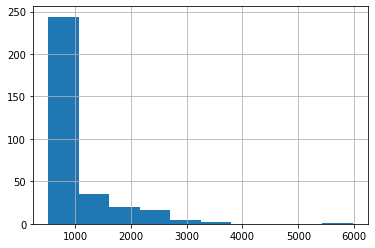

In [143]:
# visualize transaction distribution by pf based on query.
shoreline_df.query("date < 2010 and area > 1000 and area < 1200").sort_values(by=['date']).pf.hist()

Might the units with crazy pf figures be entry mistakes? i.e. extra zero to the right?

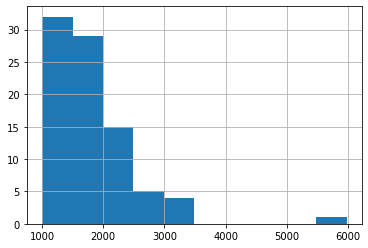

In [145]:
shoreline_df.query("date < 2010 and area > 1000 and area < 1200 and pf > 1000").sort_values(by=['date']).pf.hist()

In [147]:
shoreline_df.query("date < 2010 and area > 1000 and area < 1200 and pf > 1000").sort_values(by=['date']).shape

(86, 5)

In [649]:
# peek at some of the transactions and see if they make sense - remove the semicolon to view results
shoreline_df.query("date < 2010 and area > 1000 and area < 1200 and pf > 1000").sort_values(by=['date']);

Although high, these pf values can be real. The only one that looks like an entry error with an extra zero is tx 341205. Let's drop it. The price shown is 6842570, but I think it should be 684257.

In [150]:
shoreline_df.loc[[341205]]

,building,date,area,price,pf
341205,Al Hatimi,2009-03-22,1145,6842570,5976


In [151]:
# drop bad row
shoreline_df.drop([341205], inplace=True)

In [156]:
# looking at pf min
shoreline_df.sort_values(by=['pf'], ascending=True).head()

,building,date,area,price,pf
326740,Al Tamr,2009-04-23,4838,825000,170
327286,Al Hamri,2009-04-22,4838,825000,170
330362,Al Dabas,2009-01-03,4838,825000,170
326033,Al Khushkar,2009-07-14,4838,825000,170
329954,Al Anbara,2009-04-27,4855,825000,170


In [157]:
shoreline_df.describe()

,area,price,pf
count,4290.000000,4.290000e+03,4290.000000
mean,1867.500932,1.861836e+06,1027.505828
std,743.073008,1.119250e+06,508.973692
min,720.000000,6.000000e+05,170.000000
25%,1551.000000,1.150000e+06,550.000000
50%,1634.000000,1.600000e+06,940.000000
75%,2159.000000,2.400000e+06,1352.000000
max,5563.000000,1.350000e+07,3417.000000


In [168]:
shoreline_df.query("pf < 498").shape

(39, 5)

In [167]:
shoreline_df.query("pf < 498 and date > 2010").sort_values(by=['pf'], ascending=False)

,building,date,area,price,pf
331767,Al Hallawi,2013-10-03,1583,720000,455
340510,Al Shahla,2013-11-07,5236,2350000,449
337641,Al Shahla,2015-02-04,1997,790000,396
327901,Al Habool,2021-10-13,1583,625190,395
331703,Al Hallawi,2014-03-11,1994,700000,351
327285,Al Hamri,2013-12-03,4838,1700000,351
326721,Al Tamr,2010-02-23,5236,1700000,325
326719,Al Tamr,2012-04-07,5249,1625000,310
601859,Al Khudrawi,2018-07-11,2144,643056,300
329953,Al Anbara,2019-08-26,4855,1400000,288


These transactions above look very cheap and don't make too much sense to me. I'm going to drop them as they look like gifts. How can the penthouses be sold at 200 pf? Even in 2013? It's odd and I cannot explain it. Although it could be real, we will not be focusing on penthouses in this analysis so we are safe to drop these rows. We might look at these separately in another study.

In [172]:
# drop those tx referred to above.
shoreline_df.drop(shoreline_df.query("pf < 498 and date > 2010").index, inplace=True)

In [173]:
# check data

,area,price,pf
count,4273.000000,4.273000e+03,4273.000000
mean,1858.304938,1.864685e+06,1030.421718
std,723.840932,1.120192e+06,507.843832
min,720.000000,6.000000e+05,170.000000
25%,1551.000000,1.150000e+06,552.000000
50%,1634.000000,1.600000e+06,944.000000
75%,2159.000000,2.420000e+06,1353.000000
max,5563.000000,1.350000e+07,3417.000000


In [175]:
shoreline_df.query("pf < 498")

,building,date,area,price,pf
330362,Al Dabas,2009-01-03,4838,825000,170
326720,Al Tamr,2009-02-03,5249,1050000,200
324944,Al Khushkar,2009-02-26,5236,1050000,200
336248,Al Msalli,2009-03-05,4864,825000,170
341244,Al Khudrawi,2009-04-03,5249,1114983,212
337643,Al Shahla,2009-04-19,1997,600000,300
341230,Al Khudrawi,2009-04-20,4838,893491,185
341241,Al Khudrawi,2009-04-20,5236,1115708,213
330831,Al Dabas,2009-04-20,5249,1150000,219
330835,Al Dabas,2009-04-20,5236,1150000,220


Looks like all the penthouses have ridiculously low pf. I don't understand this so I will drop all sales under 498 pf. It will not affect our analysis.

In [176]:
# drop suspect rows
shoreline_df.drop(shoreline_df.query("pf < 498").index, inplace=True)

In [177]:
shoreline_df.describe()

,area,price,pf
count,4251.000000,4.251000e+03,4251.000000
mean,1843.450953,1.869410e+06,1034.673724
std,692.108711,1.121048e+06,505.680874
min,720.000000,6.000000e+05,498.000000
25%,1551.000000,1.150000e+06,554.000000
50%,1603.000000,1.600000e+06,947.000000
75%,2159.000000,2.425000e+06,1354.000000
max,5563.000000,1.350000e+07,3417.000000


In [178]:
shoreline_df.shape

(4251, 5)

We have now a data set that looks realatively clean. The next step is to attempt to label each transaction by the apartment type. Explained below.

### Labeling transactions by their apartments type classification

Shoreline has multiple apartment layouts - 9 in total. We are trying to isolate the F-type 2br apartments for our analysis. We know these apartments have a size of about 2000 sqft, but not all of them have that size as there are some variations during construction. The analysis would be a lot easier if the transactions record included the apartment number, as that would clearly tell us which transaction corresponds to which layout. Since we are missing that data point, we will attempt to map each transaction to its layout-type based on its size. I can do this as I know what the size of each layout is meant to be. This clustering section goes beyond what is needed to indentify the 2br and 2000 sqft apartments and attempts to match all transactions to its correponding layouts, as I will use this classification in a future study including 1br apartments.

In [92]:
# import kmeans algo from sklearn
from sklearn.cluster import KMeans

In [496]:
# look at the area distribution
shoreline_df.area.describe()

count    4251.000000
mean     1843.450953
std       692.108711
min       720.000000
25%      1551.000000
50%      1603.000000
75%      2159.000000
max      5563.000000
Name: area, dtype: float64

The number of clusters should be 9, as there are 9 distinct layouts. However, I realized that doing this prevented the algorithm to distinguish between two 2br layouts that have very similar sizes (1550 and 1590 respectively), merging them into the same cluster. By inspection, I realized that the largest penthouse type had in some instances sizes larger than expected (this would have been a result of the building process) - the typical large penthouse is around 5250 sqft but some were built at 5562. I know this as I am familiar with this development. Adding a 10th cluster allows the algorith to place this larger penthouse in a separate cluster and place the two 2br layouts into their appropriate clusters, instead of merging them into one.

In [503]:
# a view at the largest areas - these created the issue described above
shoreline_df.area.sort_values(ascending=False).head(20).values

array([5563, 5563, 5563, 5563, 5563, 5563, 5563, 5563, 5563, 5563, 5563,
       5563, 5421, 5255, 5255, 5255, 5255, 5253, 5249, 5249])

In [209]:
# run clustering algo
kmeans_area = KMeans(n_clusters=10, random_state=0).fit(np.array(shoreline_df.area).reshape(-1, 1))

In [212]:
# show the cluster centers - these numbers represent the corresponding size in sqft
# that each layout is meant to have and allow us to map transactions to its corresponding layout
kmeans_area.cluster_centers_.T

array([[1998.75638842, 5242.08695652, 1590.85298869, 1145.49589041,
        2162.17199559,  725.32352941, 4855.70149254, 2221.30885529,
        5552.07692308, 1550.95472703]])

In [214]:
# each transaction will be labeled based on their proximity to each cluster
kmeans_area.labels_

array([7, 4, 2, ..., 9, 4, 4], dtype=int32)

These clusters below correspond to the H-Type penthouse and should be merged into a single cluster - we will do this manually in a following study but for now we can ignore these as they are not relevant to this particular study.

In [215]:
# H type clusters to be merged later
print(kmeans_area.cluster_centers_[1])
print(kmeans_area.cluster_centers_[8])

[5242.08695652]
[5552.07692308]


We append the cluster labels to the shoreline_df to map them to their corresponding layout.

In [217]:
# append cluster labels i.e. layouts.
shoreline_df['layout_label'] = kmeans_area.labels_

Lets build a dictionary mapping cluster labels to layout names.

In [218]:
# view clusters
kmeans_area.cluster_centers_.T

array([[1998.75638842, 5242.08695652, 1590.85298869, 1145.49589041,
        2162.17199559,  725.32352941, 4855.70149254, 2221.30885529,
        5552.07692308, 1550.95472703]])

Cluster sizes:
array([[1998.75638842, 5242.08695652, 1590.85298869, 1145.49589041,
        2162.17199559,  725.32352941, 4855.70149254, 2221.30885529,
        5552.07692308, 1550.95472703]])

In shoreline, layouts are classified by letters - the ```cluster_layout_name_dic``` dictionary below maps each cluster to its corresponding type and ```layout_beds_dic``` maps each layout type to the number of bedrooms it has. This will allow us to isolate the f-type 2br apartment which is the subject of our study.

In [219]:
# mapping: layout name corresponding to each cluster, by size
# {cluster: layout type}
cluster_layout_name_dic = {0: 'f', 1: 'h', 2: 'e', 3: 'b', 4: 'a', 5: 'j',
                           6: 'g', 7: 'c', 8: 'h', 9: 'd'}
# bedroom count by layout class
# {layout type: bedroom count}
layout_beds_dic = {'f': 2, 'h': 4, 'e': 2, 'b': 1, 'a': 3, 'j': 1,
                   'g': 4, 'c': 3, 'h': 4, 'd': 2}

In [220]:
shoreline_df.head(1)

,building,date,area,price,pf,layout_label
330110,Al Dabas,2009-01-03,2213,1150000,520,7


In [222]:
# add column with layout class
shoreline_df['layout'] = shoreline_df.layout_label.map(cluster_layout_name_dic)

In [224]:
# add column with bedroom count
shoreline_df['beds'] = shoreline_df.layout.map(layout_beds_dic)

In [227]:
shoreline_df.head(3)

,building,date,area,price,pf,layout_label,layout,beds
330110,Al Dabas,2009-01-03,2213,1150000,520,7,c,3
330619,Al Dabas,2009-01-03,2159,1275000,591,4,a,3
330616,Al Dabas,2009-01-03,1603,800000,499,2,e,2


Looks like we have managed to label the layouts and bed counts using clustering by apartment size. A caveat is that in some instances, due to building tolerance errors, we might have some mislabled units between a-c and e-d pairs, as sizes might overlap between these. In my experience this does not happen too often so we are probably safe. Regardless, these layouts are not the subject of this study. Part of the reason for choosing the f-type 2br apartment is that its size can be clearly distinguished from the rest thus allowing us to have it clearly labeled with a very high degree of confidence.

### Diving into the f-type 2br apartment: price analysis

We can finally isolate the f-type apartment and get to analyzing the difference in price between those with a sea view and those without it. We want to isolate the view price component and see what price it commands. This is the last step of the data preparation process before stepping into modeling.

In [239]:
# create sea and park dataframes holding f types
sea_fs = shoreline_df.query("building in @sea_shorelines and layout == 'f'").copy()
park_fs = shoreline_df.query("building in @park_shorelines and layout == 'f'").copy()

In [240]:
# sort by date
sea_fs.sort_values(by=['date'], inplace=True)
park_fs.sort_values(by=['date'], inplace=True)

In [241]:
print(f"sales in the sea: {sea_fs.shape[0]}")
print(f"sales in the park: {park_fs.shape[0]}")

sales in the sea: 268
sales in the park: 319


There is a similar number of sales in both sets. Bear in mind the park side has 10 buildings to choose from, while the sea side only has 9 - one of the sea side buildings is operated as a lease-only building and has had zero sales since built.

In [243]:
sea_fs.describe()

,area,price,pf,layout_label,beds
count,268.000000,2.680000e+02,268.000000,268.0,268.0
mean,1994.425373,2.344180e+06,1175.847015,0.0,2.0
std,9.226145,1.201120e+06,603.422141,0.0,0.0
min,1975.000000,1.050000e+06,520.000000,0.0,2.0
25%,1994.000000,1.150000e+06,577.000000,0.0,2.0
50%,1994.000000,2.465000e+06,1236.500000,0.0,2.0
75%,1997.000000,3.342500e+06,1672.750000,0.0,2.0
max,2019.000000,6.500000e+06,3291.000000,0.0,2.0


In [244]:
park_fs.describe()

,area,price,pf,layout_label,beds
count,319.000000,3.190000e+02,319.000000,319.0,319.0
mean,2002.394984,1.733342e+06,865.253918,0.0,2.0
std,14.837933,6.685018e+05,332.946255,0.0,0.0
min,1975.000000,1.025000e+06,508.000000,0.0,2.0
25%,1995.500000,1.050000e+06,527.000000,0.0,2.0
50%,1997.000000,1.672702e+06,828.000000,0.0,2.0
75%,2000.000000,2.230000e+06,1103.500000,0.0,2.0
max,2055.000000,3.900000e+06,1950.000000,0.0,2.0


We can easily see there is a difference in price and pf between both sets. The median pf in the sea side is 1236 while the in park is only 828. The min is very similar, but the max diverges significanlty. Let's look at the top sales for both sides and see if there is anything weird. As an extension, we could calculate inflation-adjusted prices, but we will ignore that for now as as we are comparing transactions between both locations at the time they happened, so there is no need for that adjustment.

#### Let's look at the all time highs and lows of transaction prices for both sides.

In [504]:
# top sales of all time on the sea side
sea_fs.sort_values(by=['price'], ascending=False).head(5)

,building,date,area,price,pf,layout_label,layout,beds,Q
330653,Al Dabas,2009-01-03,1975,6500000,3291,0,f,2,2009Q1
341399,Al Khudrawi,2009-04-03,1994,6100000,3059,0,f,2,2009Q2
341210,Al Hatimi,2009-03-22,1994,5800000,2909,0,f,2,2009Q1
336013,AL HASEER B7,2014-02-07,1994,5300000,2658,0,f,2,2014Q1
327447,Al Basri,2009-04-22,1994,5067000,2541,0,f,2,2009Q2


In [505]:
# top sales of all time on the park side
park_fs.sort_values(by=['price'], ascending=False).head(5)

,building,date,area,price,pf,layout_label,layout,beds,Q
328471,Al Habool,2010-08-02,2000,3900000,1950,0,f,2,2010Q3
327707,Al Hamri,2009-09-14,1975,3800000,1924,0,f,2,2009Q3
328495,Al Habool,2016-09-20,2000,3785000,1892,0,f,2,2016Q3
378450,Abu Keibal,2009-04-23,2000,3700000,1850,0,f,2,2009Q2
375862,Al Khushkar,2009-08-24,2055,3656000,1779,0,f,2,2009Q3


In [518]:
# lowest sea sale prices
# we consider sales after 2011 as before that we have mostly transactions done at the original prices
sea_fs.sort_values(by=['price'], ascending=True).query("date > 2011").head(7)

,building,date,area,price,pf,layout_label,layout,beds,Q
329996,Al Sultana,2012-10-16,1997,2000000,1002,0,f,2,2012Q4
337475,Al Hatimi,2019-03-04,1997,2170000,1087,0,f,2,2019Q1
436100,AL NABAT B8,2019-09-29,1994,2306000,1156,0,f,2,2019Q3
328010,Al Basri,2020-03-15,1997,2377400,1190,0,f,2,2020Q1
342245,AL HASEER B7,2011-01-16,1997,2398736,1201,0,f,2,2011Q1
341903,Al Khudrawi,2020-05-11,1994,2450000,1229,0,f,2,2020Q2
330992,Al Sultana,2012-09-24,1994,2480000,1244,0,f,2,2012Q3


In [520]:
# lowest park sale prices
# we consider sales after 2012 as before that we have mostly transactions done at the original prices
park_fs.sort_values(by=['price'], ascending=True).query("date > 2012").head(5)

,building,date,area,price,pf,layout_label,layout,beds,Q
331704,Al Hallawi,2012-02-04,1994,1250000,627,0,f,2,2012Q1
341347,Al Shahla,2012-04-30,1997,1300000,651,0,f,2,2012Q2
332786,JASH HAMAD - B18,2020-11-25,2040,1330000,652,0,f,2,2020Q4
330439,Al Hallawi,2019-11-17,2012,1400000,696,0,f,2,2019Q4
330437,Al Hallawi,2019-05-12,2012,1400000,696,0,f,2,2019Q2


Looking at the top sales, we can see that the highest occured around 2009-2010 which is when the building were completed. For sea and park we have 6.5m in 2009 and 3.9m in 2010 respectively. After that, the highest sales for a sea and park apartments were in 2014 for 5.3m and in 2016 for 3.78m.  Looking at the lows we can see the years 2019-2020 dominate - this is when Dubai prices bottomed out before prices started to increase in 2021.

The dataset is ready for the modeling section where we will attempt to isolate the price component of having a sea view.

## 3. Modeling and evaluation <a name="modeling"></a>

[(back to index)](#top)

The goal of this section is to construct a time series of prices for both the park and sea buildings that can be compared against each other to extract a number that conveys information about the price component of having a sea view. We need to transform the data in some way that allows us to make comparisons between both sets, while avoiding to make comparisons between individual transactions. Each dataset is of different length and we cannot compare transactions at an individual level. What we need is a way to agreggate the transactions in each side and create some form of price index for each, then subtract the price index of the park from that of the sea. We can also take the proportion between both or think of other operations we might want to perform.

In simple terms:

price = b0 + b1*x1 + b2*sea_view + b3*park_view + b4*sea_side + b5*park_side + ... + bn*xn

price_sea = b0 + b1*x1 + b2*1 + b3*0 + b4*1 + b5*0 + ... + xn
price_park = b0 + b1*x1 + b2*0 + b3*1 + b4*0 + b5*1 ... + xn

price_of_sea_view = price_sea - price_park = (b2+b4) - (b3+b5)

Since the buildings are only about 30 meters apart, we will assume that the location components << view components, i.e. b4,b5 << b2,b3. In all other regards, the apartments are the same, hence all other terms cancel out.

Therefore:
price_of_sea_view = b2-b3


Lets explore a few ways to come up with that number. Some ideas are:
- Calculate the rolling average over each set to smoothen the peaks, then see if we can find the median or mean for each set and take the difference and proportion
- Agreggate transactions by some time period, for example quarterly, then find the difference.
- Regression?

#### Exponential moving averages.
- [datacamp](https://www.datacamp.com/community/tutorials/moving-averages-in-pandas)  
- [pandas ewm](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ewm.html)

Sea side

In [277]:
# sea ewm - exponential moving average
ewm_sea_fs = sea_fs.pf.ewm(alpha=1 / 5).mean()

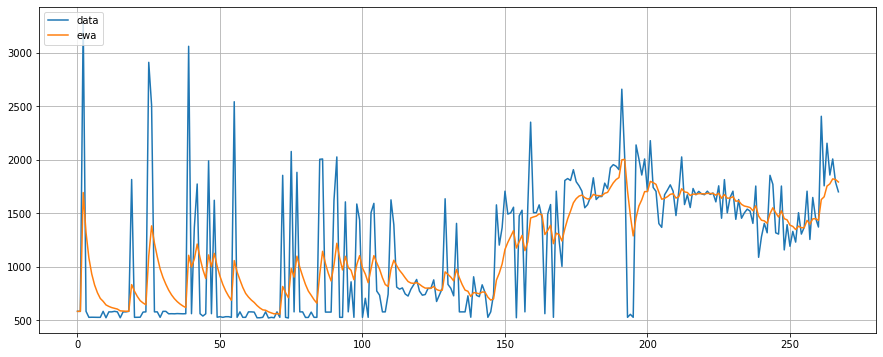

In [278]:
# visualize results
plt.figure(figsize=[15,6])
plt.grid(True)
plt.plot(sea_fs.pf.reset_index(drop=True), label='data')
plt.plot(ewm_sea_fs.reset_index(drop=True), label='ewa')
plt.legend(loc=2)

Park

In [284]:
# park ewm
ewm_park_fs = park_fs.pf.ewm(alpha=1 / 5).mean()

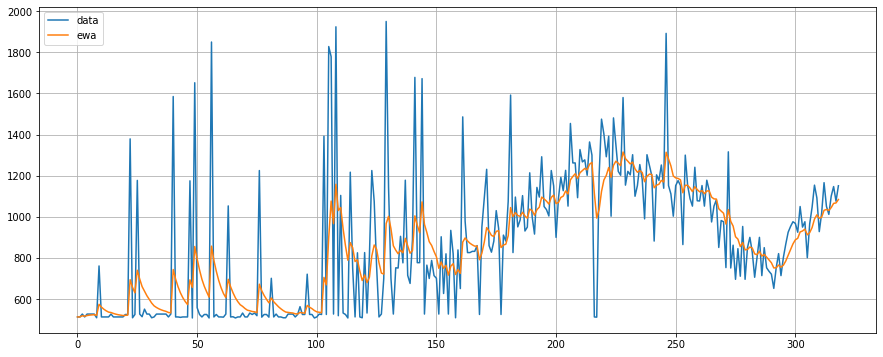

In [285]:
# visualize results
plt.figure(figsize=[15,6])
plt.grid(True)
plt.plot(park_fs.pf.reset_index(drop=True), label='data')
plt.plot(ewm_park_fs.reset_index(drop=True), label='ewa')
plt.legend(loc=2)

From the above plots, we notice that for some reason there are transactions registered at the original prices well past 2012. We know that the project sold out well before that so these are unlikely to be real sales transactions and are probably delayed registrations. We will drop all transactions under 600 pf for both sea and park and run the analysis again. This ensures we remove data points that only capture the original sales price, as those will not give us any information about how the market values the sea view.

In [287]:
# dropping rows under 600 pf
sea_fs = sea_fs.query("pf > 600").copy()
park_fs = park_fs.query("pf > 600").copy()

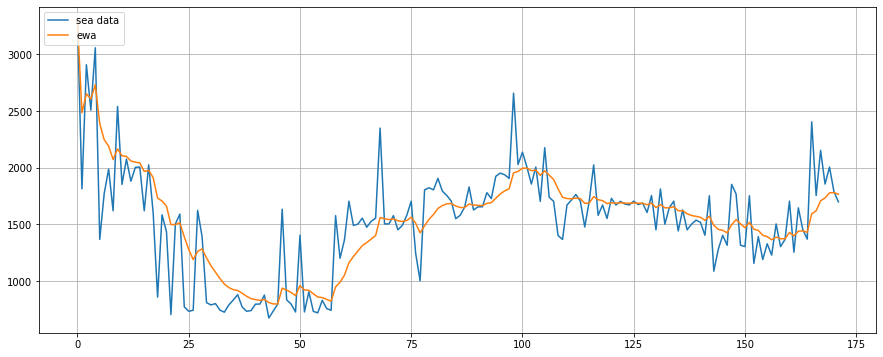

In [528]:
# sea - calculate ewm
# set the alpha term
alpha = 1/6
ewm_sea_fs = sea_fs.pf.ewm(alpha=alpha).mean()
# visualize results
plt.figure(figsize=[15,6])
plt.grid(True)
plt.plot(sea_fs.pf.reset_index(drop=True), label='sea data')
plt.plot(ewm_sea_fs.reset_index(drop=True), label='ewa')
plt.legend(loc=2)

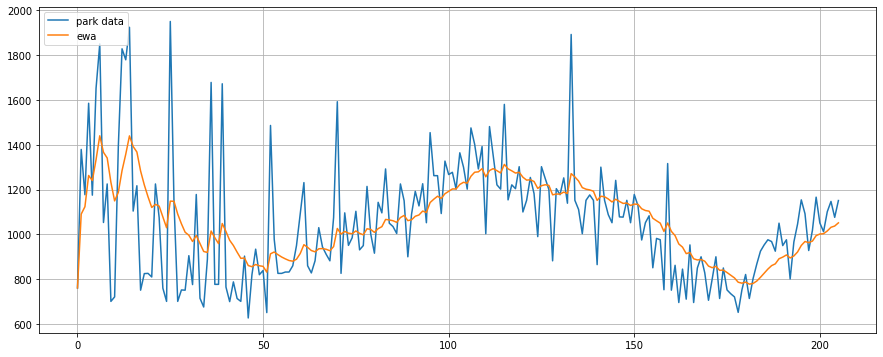

In [536]:
# park - calculate ewm
# set the alpha term
alpha = 1/8
ewm_park_fs = park_fs.pf.ewm(alpha=alpha).mean()
# visualize results
plt.figure(figsize=[15,6])
plt.grid(True)
plt.plot(park_fs.pf.reset_index(drop=True), label='park data')
plt.plot(ewm_park_fs.reset_index(drop=True), label='ewa')
plt.legend(loc=2)

We can see that the exponential moving averages helps us smooth the series. We can also notice that in both the sea and park sides there are noticeable deviations from the mean. The view is not the only factor that affects the price of an apartment; other factors include:
- Is the apartment upgraded? This generally increases the price.
- Is there a demand spike, or a shortage of supply? Or the opposite? Price increase and decrease respectively.
- Is a particular seller distressed? Price drop below mean.
- Does a particular apartment have a particular feature that a specific buyer is willing to pay more to get?

These factors are hidden variables that we cannot account for, but we know exist. Smoothing the series allows us to dampen the impact of these factors.

Can we operate between the ewm's of each series?

In [543]:
print(f"number of transactions in the sea: {ewm_sea_fs.shape[0]}")
print(f"number of transactions in the park: {ewm_park_fs.shape[0]}")

number of transactions in the sea: 172
number of transactions in the park: 206


Firstly, the length of both series is different so we cannot simply take the difference between these. We could extend the sea series to match the park length and perform some sort of interpolation to fill in the missing values, or drop values from the park series to match the size of the sea series. We would then have to include the dates in some way, and make sure we are comparing transactions taking account the date in which they took place - aggregate prices rise and fall with time, so we cannot compare a transaction that are too far apart in time. From looking at the data, I have seen that there are periods of time in which not many transactions happen for one side vs the other, so matching these two series is starting to look like a messy job. This might be a dead end. Let's look at another option, such as agreggating transactions by some temporal measure (e.g. by quarter) and operating on these - that is what we'll do next.

#### Quarterly agreggation and comparison.

We agreggate transactions by date, specifically by quarter. We expect multiple transactions to happen on each side on each quarter - we can then compute the mean or median of these and set a quarterly price, which allows us to compare both series on an equal time scale. Since we have between 170-200 transactions for a span of around 11 years (44 quarters), quartelry aggregation should result in around 3-5 transactions per quarter which should be enough to get a meaninful mean/median for each period.

In [296]:
# add a quarter column
sea_fs['Q'] = sea_fs.date.dt.to_period('Q')
park_fs['Q'] = park_fs.date.dt.to_period('Q')

As a sanity check, let's see how many transactions were registered per quarter for each side.

In [560]:
# number of transactions per quarter by the sea
sea_fs.groupby('Q').size().describe()

count    48.000000
mean      3.583333
std       3.542047
min       1.000000
25%       2.000000
50%       3.000000
75%       4.000000
max      22.000000
dtype: float64

In [561]:
# number of transactions per quarter by the park
park_fs.groupby('Q').size().describe()

count    52.000000
mean      3.961538
std       2.351149
min       1.000000
25%       2.000000
50%       3.000000
75%       5.250000
max      11.000000
dtype: float64

As expected, we have around 3-5 transactions happening each quarter, with some unusually high-volumne years. By inspection I noticed this happened around 2009-2011, but we know that most transactions here occured at the original sales prices and most are probably delayed sale registrations as discussed earlier, or merely seller's exiting their investment at the time of handover.

In [299]:
# compute the median price per quarter
quarterly_median_sea_fs = sea_fs.groupby(['Q'])['pf'].median()
quarterly_median_park_fs = park_fs.groupby(['Q'])['pf'].median()

In [304]:
# number of quarters with data for each set
print(quarterly_median_sea_fs.shape[0])
print(quarterly_median_park_fs.shape[0])

48
52


Are there quarters in which no transactions were registered in the sea?

In [551]:
# look at 2013-2014 in the sea
quarterly_median_sea_fs.iloc[19:24]

Q
2013Q4    1938.0
2014Q1    2343.0
2015Q1    2137.0
2015Q2    2006.0
2015Q4    1721.5
Freq: Q-DEC, Name: pf, dtype: float64

In [552]:
# look at 2013-2014 in the park
quarterly_median_park_fs.iloc[19:24]

Q
2013Q4    1262.0
2014Q1    1300.0
2014Q2    1342.0
2014Q3    1003.0
2014Q4    1286.5
Freq: Q-DEC, Name: pf, dtype: float64

We can see some quarters are missing in the sea dataset, meaning there were no transactions over that period. For instance, it looks like between Q2-Q4 2014 there were no sales in the sea side. This is interesting to see because that period coincides with the months before prices peaked in Dubai around the start of 2015. I will show later the apartment price index published by the government, which gives an aggregate measure of the price level across Dubai, where you can notice this peak I'm refering too. It is possible that sellers began pricing their apartment at a much higher price than what buyers were willing to transact for, and so demand dried up. We have no data of sales listing ads that could help us answer this question, so we are only speculating.

Let's visualize the median of quarterly transactions.

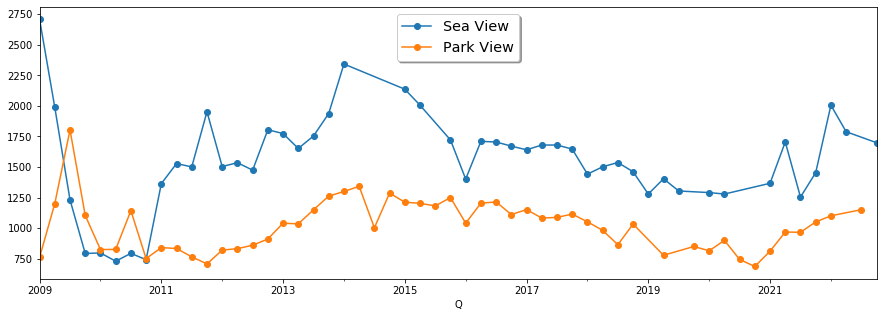

In [339]:
# visualizing quarterly median prices
ax = quarterly_median_sea_fs.plot(style="-o", figsize=[15,5], label='Sea View')
ax = quarterly_median_park_fs.plot(style="-o", figsize=[15,5], label='Park View')
ax.legend(loc='upper center', shadow=True, fontsize='x-large');

Now that we have these time series which are comparable between each other, let's look at the difference in pf between the sea and park apartments.

In [342]:
# calculate difference in price per square foot
diff_sea_park_fs = quarterly_median_sea_fs - quarterly_median_park_fs

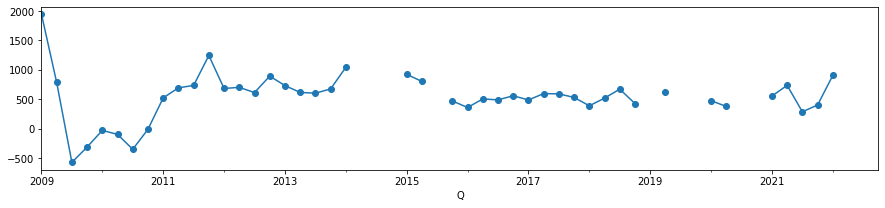

In [344]:
# plot difference between sea and park
ax = (diff_sea_park_fs).plot(style="-o", figsize=[15,3], label='Difference')

The difference appears to be somewhat constant over time, and this value would correspond to the market price of having a sea view. We have some missing values for quarters in which either the sea or park apartments registered no sales - let's fill in those missing values using linear interpolation.

In [350]:
# fill nans - some quarters have no sales hence we get some nans
diff_sea_park_fs_interpoled = diff_sea_park_fs.interpolate()

In [411]:
# look at the data stats
diff_sea_park_fs_interpoled.describe()

count      56.000000
mean      584.133929
std       390.774619
min      -572.000000
25%       475.250000
50%       594.750000
75%       749.500000
max      1947.500000
Name: pf, dtype: float64

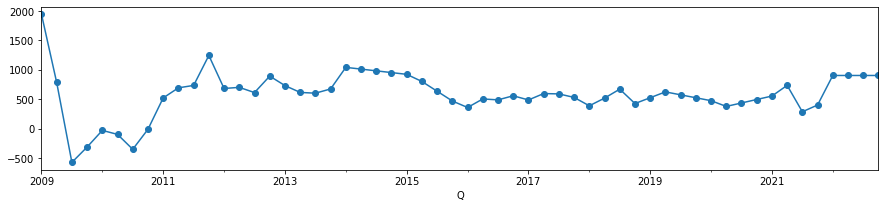

In [368]:
# plot difference between sea and park with linear interpolation
ax = (diff_sea_park_fs_interpoled).plot(style="-o", figsize=[15,3], label='Difference')

We can see that the period between 2009 and 2011 shows negative values meaning there was a period of time when the park view apartments sold for a higher price than those on the sea - this is odd and there are probably other factors to consider that go beyond my knowledge. 

Another thing to notice is that the developer might have left money on the table when pricing the sea apartments at launch. Earlier in the notebook we had a bried look at launch prices, and we can see there was not a significant difference between the sea and the park. Later on and when trading in the secondary market, the real price of the sea view emerged.

Let's explore the idea that the developer left money on the table when selling the apartments to the original buyers. Since I have reason to believe transactions between 2009-2010 Analyze transactions between 2009-2011 are, or are very close to the original prices, let's look into that time period and see what the prices were back then.

In [568]:
# lowest sales by the sea before 2012
sea_fs.query("date < 2012").sort_values(by=['price']).head()

,building,date,area,price,pf,layout_label,layout,beds,Q
436052,AL NABAT B8,2010-01-21,2012,1356500,674,0,f,2,2010Q1
327448,Al Basri,2009-11-06,1994,1403000,704,0,f,2,2009Q4
436131,AL NABAT B8,2010-05-31,1994,1434500,719,0,f,2,2010Q2
436084,AL NABAT B8,2010-04-01,1994,1450000,727,0,f,2,2010Q2
436079,AL NABAT B8,2010-02-24,1994,1450000,727,0,f,2,2010Q1


In [571]:
# what was the median price for this time period? Taking the lowest 5 transactions.
median_09_11_sea_price = sea_fs.query("date < 2012").sort_values(by=['price']).head().pf.median()

In [572]:
# lowest sales by the sea before 2012
park_fs.query("date < 2012").sort_values(by=['price']).head()

,building,date,area,price,pf,layout_label,layout,beds,Q
337672,Al Shahla,2011-04-27,1997,1350000,676,0,f,2,2011Q2
328295,Al Habool,2011-11-15,1997,1400000,701,0,f,2,2011Q4
377400,Abu Keibal,2011-08-08,2000,1400000,700,0,f,2,2011Q3
326799,Al Tamr,2010-10-19,1997,1400000,701,0,f,2,2010Q4
332149,Al Hallawi,2010-07-26,1997,1400000,701,0,f,2,2010Q3


In [573]:
# what was the median price for this time period? Taking the lowest 5 transactions.
median_09_11_park_price = park_fs.query("date < 2012").sort_values(by=['price']).head().pf.median()

In [578]:
print(f"Sea/Park median proportion: {median_09_11_sea_price / median_09_11_park_price:.2f}")

Sea/Park median proportion: 1.03


We can see that sea view apartments were only 3% more expensive than their park counterparts. This looks like the developer left a lot of money on the table.

# 4. Results <a name="results"></a>

[(back to index)](#top)

Calculating a number for the premium of having a sea view.

As a good estimate, the median and mean should give us this figure.

In [373]:
# calculate mean and median from the quarterly price differences.
diff_mean_fs = np.round(diff_sea_park_fs_interpoled.mean())
diff_median_fs = np.round(diff_sea_park_fs_interpoled.median())

In [652]:
print(f"Average premium (sea-park): {diff_mean_fs}")
print(f"Median premium (sea-park): {diff_median_fs}")

Average premium (sea-park): 584.0
Median premium (sea-park): 595.0


The average size of one of these apartments is 1998.75 sqft, which we found through the clustering section of our analysis. Let's calculate the monetary value of the sea view:

In [584]:
print(f"Cost of a sea view: AED {diff_median_fs*1998.75:,.0f}")
print(f"Cost of a sea view: USD {0.27*diff_median_fs*1998.75:,.0f}")

Cost of a sea view: AED 1,189,256
Cost of a sea view: USD 321,099


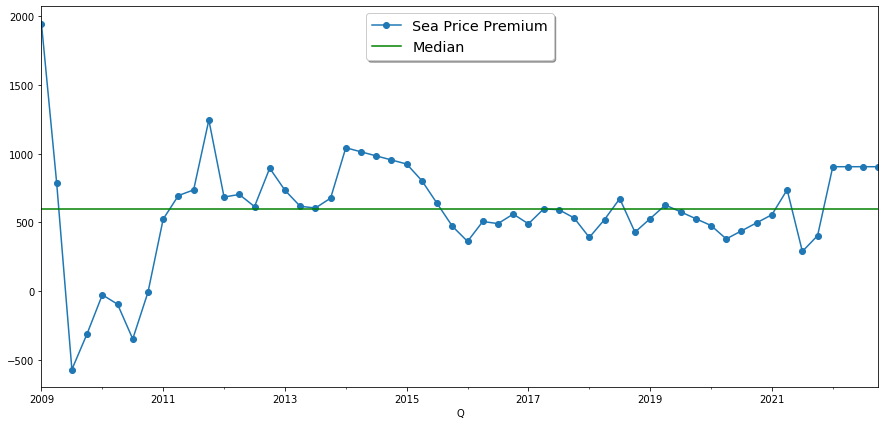

In [655]:
# visualize the difference in price per square foot between sea and park
ax = (diff_sea_park_fs_interpoled).plot(style="-o", figsize=[15,7], label='Sea Price Premium');
# show the median
ax.axhline(y=diff_median_fs, color='g', label='Median');
ax.legend(loc='upper center', shadow=True, fontsize='x-large');

We can see that although not exaclty constant, differences closely oscillate around the median.

Let's subtract the median from the sea transactions and see if it closely matches those in the park

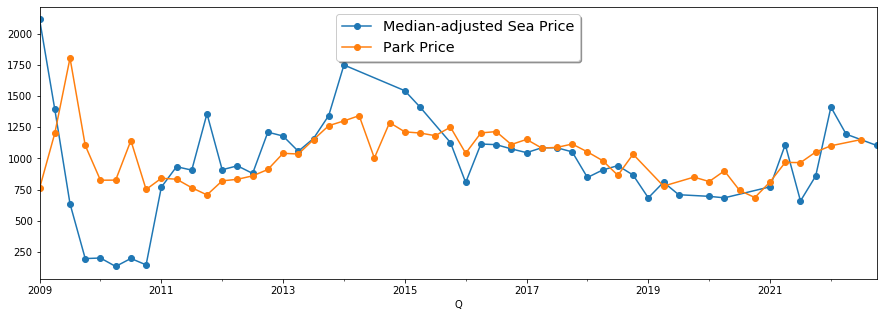

In [656]:
ax = (quarterly_median_sea_fs-diff_median_fs).plot(style="-o", figsize=[15,5], label='Median-adjusted Sea Price')
ax = quarterly_median_park_fs.plot(style="-o", figsize=[15,5], label='Park Price')
ax.legend(loc='upper center', shadow=True, fontsize='x-large');

We can see there are two particular periods where the assumption that the price difference is constant clearly breaks. (1) Between 2009-2011: I don't know what the mechanics of that market were back then, whether there were delays on the sea view or just money left on the table by the developer. (2) Between mid 2013 to 2015: we know this period of time had a major price rally and that prices peaked at the start of 2015, and so it seems that sea view apartments rise in price faster and higher than those in the park. It seems that when prices are rallying, it pays to have a sea view. I will add Dubai's general price index in a later section that you can refer to.

#### Looking at the percentage price differences between sea and park

In [405]:
# calculate percentage difference
percentage_sea_park_fs = (quarterly_median_sea_fs / quarterly_median_park_fs)

In [406]:
# fill nans - some quarters have no sales hence we get some nans
percentage_sea_park_fs_interpoled = percentage_sea_park_fs.interpolate()

In [407]:
# calculate mean and median
perc_diff_mean_fs = np.round(percentage_sea_park_fs_interpoled.mean(), decimals=2)
perc_diff_median_fs = np.round(percentage_sea_park_fs_interpoled.median(), decimals=2)

In [408]:
print(f"mean percentage difference (sea-park): {perc_diff_mean_fs}")
print(f"median percentage difference (sea-park): {perc_diff_median_fs}")

mean percentage difference (sea-park): 1.6
median percentage difference (sea-park): 1.6


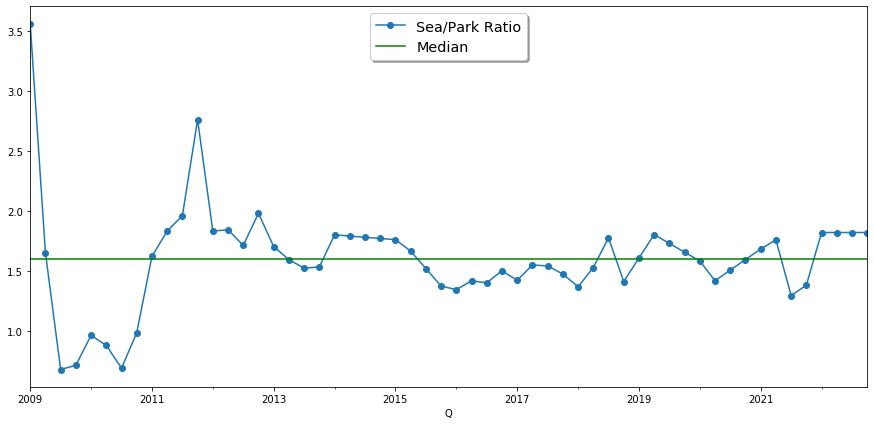

In [657]:
# plot results
ax = (percentage_sea_park_fs_interpoled).plot(style="-o", figsize=[15,7], label='Sea/Park Ratio');
# show the median
ax.axhline(y=perc_diff_median_fs, color='g', label='Median');
ax.legend(loc='upper center', shadow=True, fontsize='x-large');

In [410]:
# quartelry results
percentage_sea_park_fs_interpoled.describe()

count    56.000000
mean      1.600648
std       0.435151
min       0.682839
25%       1.420900
50%       1.603052
75%       1.784881
max       3.559133
Name: pf, dtype: float64

We can see that on average, a sea view apartment will be 60% more expensive than the same apartment with a park view. Compare this against the 3% we found earlier and which I believe was around the price difference the developer priced the apartments during the original launch. If this is true, there was potentially a lot of money left on the table.

I mentioned earlier the Dubai general price index, and made references to the 2015 price peak. I will include the apartment index below for those curious to see what it looks like. Note 

We can see that between 2009-2013, there are very high oscillations in the difference between sea and park prices, which stabilize after 2013. Remember that the project was completed in 2009, and so it seems it took around 3 years for the market to make up its mind about what price to attribute to the view. We have also discussed that some transactions during that period happened at the original sales price, and some at very high prices. If you ever took a physics course, you might have heard the concept of [damped harmonic motion](https://www.toppr.com/guides/physics/oscillations/damped-simple-harmonic-motion/) - the graph resembles the motions of such a system. The period 2009-2013 would be the transient phase, and 2013-2022 the steady state.

### Steady-state premiums: isolate the period between 2013 and 2022.

We define the period 2009-2013 as the transient phase, and 2013-2022 as the steady state of they system. Also, we note that the the park and sea sets have a transaction each whose date was incorrectly parsed. The data is current up to 12 April 2022 but records with id 327059 and 341898 have dates in July and November, which is impossible. This is due to month-day being entered incorreclty in the data (see below). For this reason, we will drop anything after 2022Q1.

#### Stady state quartelry median price comparison

In [777]:
sea_fs.head(2)

,building,date,area,price,pf,layout_label,layout,beds,Q
330653,Al Dabas,2009-01-03,1975,6500000,3291,0,f,2,2009Q1
329997,Al Sultana,2009-02-03,1997,3623185,1814,0,f,2,2009Q1


In [778]:
# compute the median price per quarter
quarterly_median_sea_price_usd = sea_fs.groupby(['Q'])['price'].median()*.27 # to usd-aed
quarterly_median_park_price_usd = park_fs.groupby(['Q'])['price'].median()*.27 # to us-aed

In [783]:
# isolate the steady-state (post 2011), and remove dates past 2022Q1 - on price per square foot
steady_state_quarterly_median_sea_price_usd = pd.DataFrame(quarterly_median_sea_price_usd).reset_index().\
                  query("Q > '2010Q4' and Q < '2022Q1'").set_index('Q').squeeze()

steady_state_quarterly_median_park_price_usd = pd.DataFrame(quarterly_median_park_price_usd).reset_index().\
                  query("Q > '2010Q4' and Q < '2022Q1'").set_index('Q').squeeze()

In [827]:
# sea view describe
steady_state_quarterly_median_sea_price_usd.describe()

count    3.700000e+01
mean     8.652055e+05
std      1.348149e+05
min      6.750000e+05
25%      7.762500e+05
50%      8.302500e+05
75%      9.247500e+05
max      1.262250e+06
Name: price, dtype: float64

In [826]:
# park view describe
steady_state_quarterly_median_park_price_usd.describe()

count        42.000000
mean     545775.001071
std       97514.426461
min      373950.000000
25%      454950.000000
50%      557887.500000
75%      631125.000000
max      724224.240000
Name: price, dtype: float64

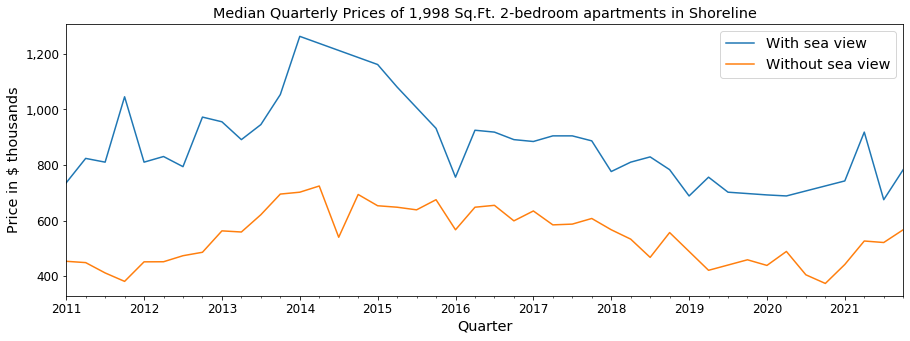

In [884]:
fig, axs = plt.subplots(figsize=(15,5))

(steady_state_quarterly_median_sea_price_usd/1000).plot(ax=axs, label="With sea view");
(steady_state_quarterly_median_park_price_usd/1000).plot(ax=axs, label="Without sea view");
axs.legend(loc="best", fontsize="x-large");
axs.set_title("Median Quarterly Prices of 1,998 Sq.Ft. 2-bedroom apartments in Shoreline", fontsize="x-large");
#axs.xaxis.set_label_text("Quarter", fontsize="x-large");
axs.set_xlabel("Quarter", fontsize="x-large")
#axs.yaxis.set_label_text("Price in $ thousands", fontsize="x-large");
axs.set_ylabel("Price in $ thousands", fontsize="x-large");

# set ticks fontsize
for label in (axs.get_xticklabels() + axs.get_yticklabels()):
    label.set_fontsize(12)
    
# format price in thousands
axs.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

#### Steady-state price ratio

In [828]:
# ratio between sea and park between 2011-2012
steady_state_ratio_usd = steady_state_quarterly_median_sea_price_usd / steady_state_quarterly_median_park_price_usd


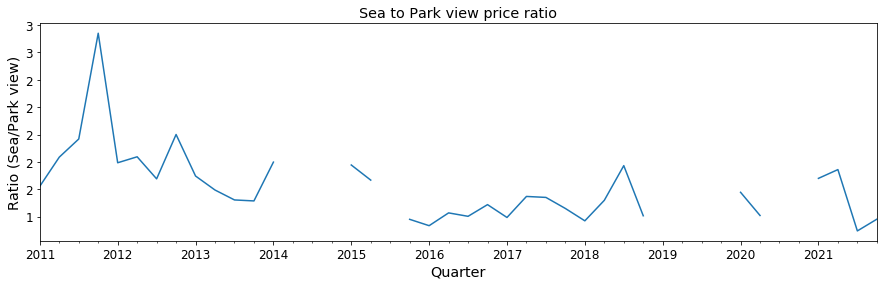

In [829]:
fig, axs = plt.subplots(figsize=(15,4))

(steady_state_ratio_usd).plot(ax=axs, label="With sea view");
#axs.legend(loc="best", fontsize="x-large");
axs.set_title("Sea to Park view price ratio", fontsize="x-large");
#axs.xaxis.set_label_text("Quarter", fontsize="x-large");
axs.set_xlabel("Quarter", fontsize="x-large")
#axs.yaxis.set_label_text("Price in $ thousands", fontsize="x-large");
axs.set_ylabel("Ratio (Sea/Park view)", fontsize="x-large");

# set ticks fontsize
for label in (axs.get_xticklabels() + axs.get_yticklabels()):
    label.set_fontsize(12)
    
# format price in thousands
axs.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

#### Steady-state premium in USD

In [885]:
# ratio between sea and park between 2011-2012
steady_state_premium_usd = steady_state_quarterly_median_sea_price_usd - steady_state_quarterly_median_park_price_usd


In [888]:
# resolve nans with linear interpolation
steady_state_premium_usd_interpolated = steady_state_premium_usd.interpolate()

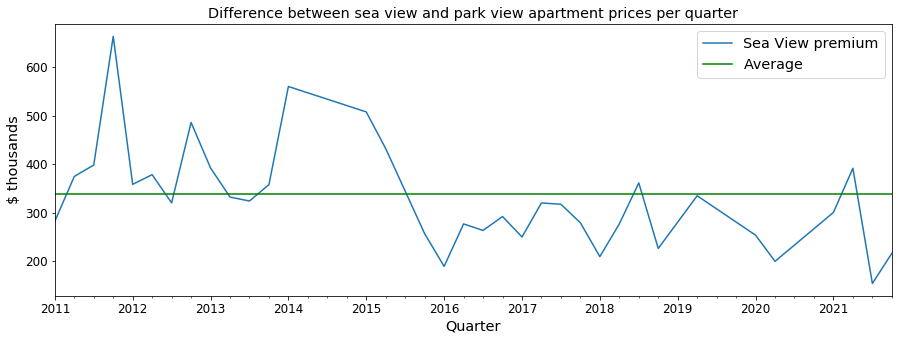

In [896]:
fig, axs = plt.subplots(figsize=(15,5))

(steady_state_premium_usd_interpolated/1000).plot(ax=axs, label="Sea View premium");

axs.set_title("Difference between sea view and park view apartment prices per quarter", fontsize="x-large");
axs.axhline(y=steady_state_premium_usd_interpolated.mean()/1000, color='g', label='Average');
#axs.xaxis.set_label_text("Quarter", fontsize="x-large");
axs.set_xlabel("Quarter", fontsize="x-large")
#axs.yaxis.set_label_text("Price in $ thousands", fontsize="x-large");
axs.set_ylabel("$ thousands", fontsize="x-large");
axs.legend(loc="best", fontsize="x-large");

# set ticks fontsize
for label in (axs.get_xticklabels() + axs.get_yticklabels()):
    label.set_fontsize(12)
    
# format price in thousands
axs.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

#### Steady-state premiums per square foot

In [604]:
# date erros in park
park_fs.loc[[327059]]

,building,date,area,price,pf,layout_label,layout,beds,Q
327059,Al Hamri,2022-07-04,1998,2300000,1151,0,f,2,2022Q3


In [609]:
# date error in sea
sea_fs.loc[[341898]]

,building,date,area,price,pf,layout_label,layout,beds,Q
341898,Al Khudrawi,2022-11-02,1994,3387500,1699,0,f,2,2022Q4


In [762]:
# isolate the steady-state (post 2011), and remove dates past 2022Q1 - on price per square foot
steady_state_pf = pd.DataFrame(diff_sea_park_fs_interpoled).reset_index().\
                  query("Q > '2010Q4' and Q < '2022Q1'").set_index('Q').squeeze()

In [763]:
# calculate mean and median from the quarterly price differences.
diff_mean_steady = np.round(steady_state_pf.mean())
diff_median_steady = np.round(steady_state_pf.median())

In [764]:
print(f"mean difference (sea-park): {diff_mean_steady}")
print(f"median difference (sea-park): {diff_median_steady}")

mean difference (sea-park): 630.0
median difference (sea-park): 595.0


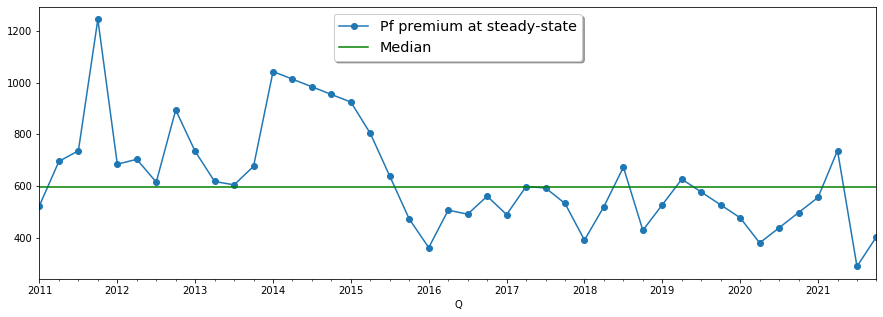

In [765]:
# visualize the difference in price per square foot between sea and park
ax = (steady_state_pf).plot(style="-o", figsize=[15,5], label='Pf premium at steady-state');
# show the median
ax.axhline(y=diff_median_steady, color='g', label='Median');
ax.legend(loc='upper center', shadow=True, fontsize='x-large');

In [766]:
# stats describing the steady state
steady_state_pf.describe()

count      44.000000
mean      630.079545
std       204.250295
min       288.000000
25%       495.125000
50%       594.750000
75%       710.625000
max      1245.000000
Name: pf, dtype: float64

Let's compare the price-spread distributions for the whole 2009-2022 and steady-state 2013-2022 periods.

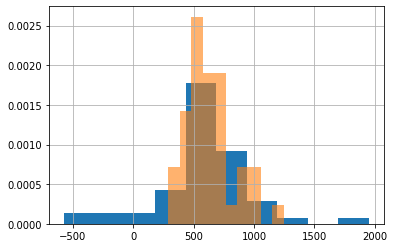

In [767]:
# plotting the price spread distributions
# TODO: format the graph
diff_sea_park_fs_interpoled.hist(density=True)
steady_state_pf.hist(density=True, alpha=0.6)

#### Steady-state premiums ratio

In [835]:
# isolate the steady-state ratio (post 2013), and remove dates past 2022Q1
steady_state_ratio = pd.DataFrame(percentage_sea_park_fs_interpoled).reset_index().\
                  query("Q > '2010Q4' and Q < '2022Q1'").set_index('Q').squeeze()

In [836]:
# calculate mean and median from the quarterly price differences.
ratio_mean_steady = steady_state_ratio.mean()
ratio_median_steady = steady_state_ratio.median()

In [837]:
print(f"Steady-state mean ratio (sea-park): {ratio_mean_steady:.2f}")
print(f"Steady-state median ratio (sea-park): {ratio_median_steady:.2f}")

Steady-state mean ratio (sea-park): 1.64
Steady-state median ratio (sea-park): 1.60


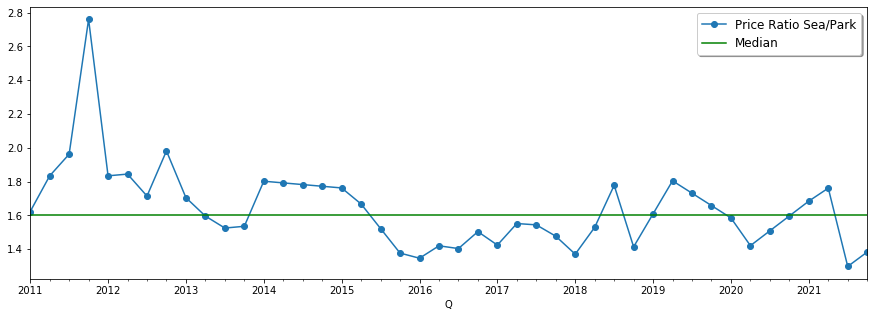

In [844]:
# visualize the difference in price per square foot between sea and park
ax = steady_state_ratio.plot(style="-o", figsize=[15,5], label='Price Ratio Sea/Park');
# show the median
ax.axhline(y=ratio_median_steady, color='g', label='Median');
ax.legend(loc='best', shadow=True, fontsize='large');

In [839]:
# stats describing the steady state
steady_state_ratio.describe()

count    44.000000
mean      1.640949
std       0.244589
min       1.298137
25%       1.497320
50%       1.603052
75%       1.773801
max       2.759717
Name: pf, dtype: float64

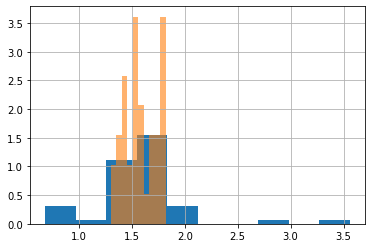

In [751]:
# plotting the price spread distributions
# TODO: format the graph
percentage_sea_park_fs_interpoled.hist(density=True)
steady_state_ratio.hist(density=True, alpha=0.6)

### A view into Dubai's apartment market-price index

Dataset [source](https://www.dubaipulse.gov.ae/data/dld-transactions/dld_residential_sale_index-open)

In [412]:
# open data
price_index = pd.read_csv("Residential_Sale_Index.csv")

In [413]:
price_index.head(2)

,first_date_of_month,all_monthly_index,all_quarterly_index,all_yearly_index,flat_monthly_index,flat_quarterly_index,flat_yearly_index,villa_monthly_index,villa_quarterly_index,villa_yearly_index,all_monthly_price_index,all_quarterly_price_index,all_yearly_price_index,flat_monthly_price_index,flat_quarterly_price_index,flat_yearly_price_index,villa_monthly_price_index,villa_quarterly_price_index,villa_yearly_price_index
0,01-03-2011,1.019,NaN,NaN,1.034,NaN,NaN,1.035,NaN,NaN,992984.0,NaN,NaN,973739.0,NaN,NaN,1612610.0,NaN,NaN
1,01-04-2011,1.018,NaN,NaN,1.032,NaN,NaN,1.016,NaN,NaN,1000907.0,NaN,NaN,981915.0,NaN,NaN,1583663.0,NaN,NaN


In [414]:
price_index.shape

(128, 19)

Let's take a view with date as index and the monthly apartment index.

In [434]:
monthly_apt_index = pd.DataFrame(price_index.loc[:, ['first_date_of_month', 'flat_monthly_index']])

In [435]:
monthly_apt_index.head(1)

,first_date_of_month,flat_monthly_index
0,01-03-2011,1.034


In [436]:
# cast the date column as datetime
monthly_apt_index.loc[:, 'date'] = pd.to_datetime(monthly_apt_index['first_date_of_month'], format="%d-%m-%Y")

In [437]:
monthly_apt_index.head(1)

,first_date_of_month,flat_monthly_index,date
0,01-03-2011,1.034,2011-03-01


By inspecting the dataset, I noticed that there appear to be some errors in the quartelry calculations, so I'll be constructing my own based on the monthly index values.

In [460]:
# set quarter column
monthly_apt_index['Q'] = monthly_apt_index.date.dt.to_period('Q')

In [443]:
# set monthly column
monthly_apt_index['M'] = monthly_apt_index.date.dt.to_period('M')

In [445]:
# make M the index
monthly_apt_index.set_index('M', inplace=True)

In [461]:
monthly_apt_index.head(1)

,first_date_of_month,flat_monthly_index,date,Q
M,,,,
2011-03,01-03-2011,1.034,2011-03-01,2011Q1


In [451]:
# sort by date - the original data is not sorted
monthly_apt_index.sort_values(by=['date'], inplace=True)

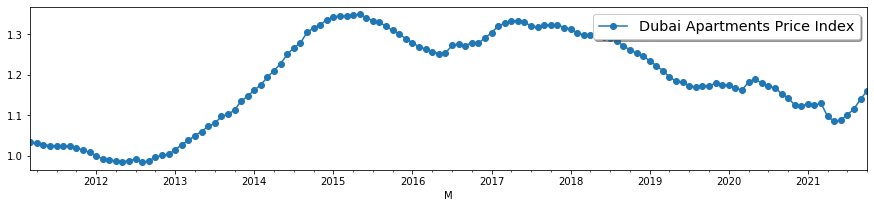

In [661]:
# plot index - by month
ax = monthly_apt_index['flat_monthly_index'].plot(style="-o", figsize=[15,3], label='Dubai Apartments Price Index');
# show the median
ax.legend(loc='upper right', shadow=True, fontsize='x-large');

In [466]:
# get quarterly results
quarterly_apt_index = monthly_apt_index.drop_duplicates(subset=['Q'], keep='last').copy()

In [468]:
# set quarter as index
quarterly_apt_index.set_index('Q', inplace=True)

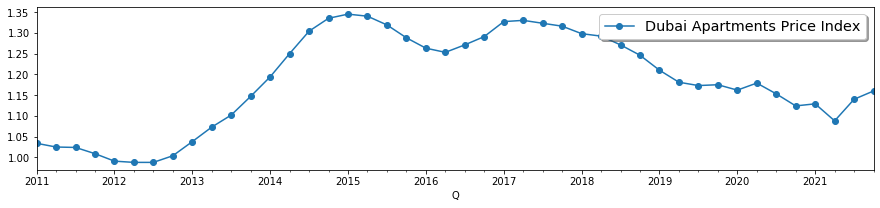

In [662]:
# plot results - by quarter
ax = quarterly_apt_index['flat_monthly_index'].plot(style="-o", figsize=[15,3], label='Dubai Apartments Price Index');
# show the median
ax.legend(loc='upper right', shadow=True, fontsize='x-large');

#### Now that we have our quarterly price index, let's plot it together with the price differences for the F-types.

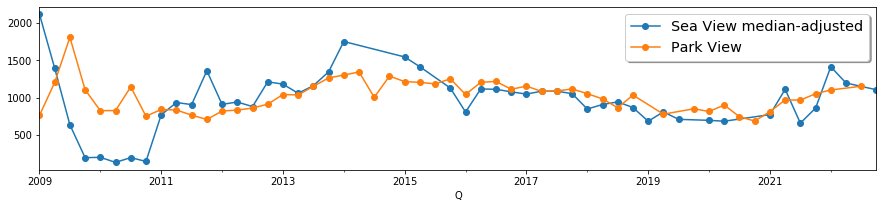

In [588]:
ax = (quarterly_median_sea_fs-diff_median_fs).plot(style="-o", figsize=[15,3], label='Sea View median-adjusted')
ax = quarterly_median_park_fs.plot(style="-o", figsize=[15,3], label='Park View')
ax.legend(loc='upper right', shadow=True, fontsize='x-large');

Looking at the price index and the sea-view adjusted median, we notice that the adjustment generally overshoots during periods of rising prices and undershoots during periods of falling prices. This looks like when confidence is high, a sea view commands a much greater premium than during periods when market confidence is low. Buying and selling a sea view apartment during a period of rising prices can generate better returns than doing the same without the view. The opposite holds: buying a sea view apartment and selling it during a falling market will get you a higher loss rate than an apartment without the sea view.

## Let's compare the price index against our steady-state price spread - 2011 to 2022.

In [769]:
# isolate the price index between 2013-2022
price_index_steady = pd.DataFrame(quarterly_apt_index).reset_index().\
                      query("Q > '2010Q4' and Q < '2022Q1'").set_index('Q')

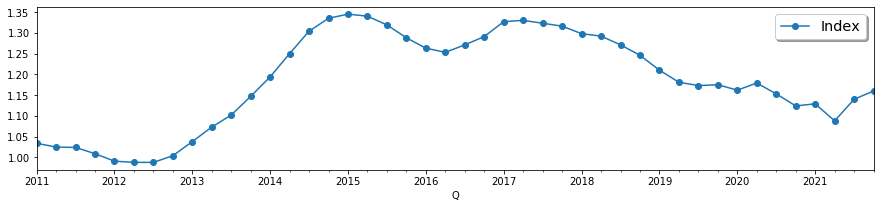

In [770]:
# plot results - by quarter
ax = price_index_steady['flat_monthly_index'].plot(style="-o", figsize=[15,3], label='Index');
# show the median
ax.legend(loc='upper right', shadow=True, fontsize='x-large');

In [ ]:
steady_state_ratio.plot(style="-o", figsize=[15,5], label='Price Ratio Sea/Park')

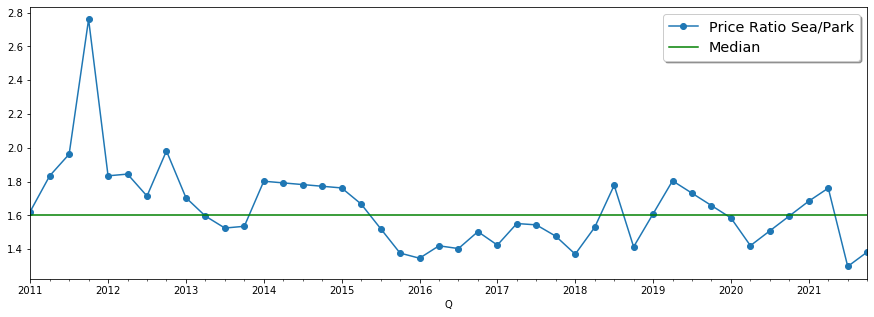

In [847]:
# visualize the total difference between sea and park
# USD ON Y AXIS - 0.27 usd per aed
# on the average size of an f type: 1998 sqft
#ax = (steady_state_pf*1998*.27).plot(style="-o", figsize=[15,3], label='Price spread at steady-state');
ax=steady_state_ratio.plot(style="-o", figsize=[15,5], label='Price Ratio Sea/Park')
# show the median
ax.axhline(y=steady_state_ratio.median(), color='g', label='Median');
ax.legend(loc='best', shadow=True, fontsize='x-large');

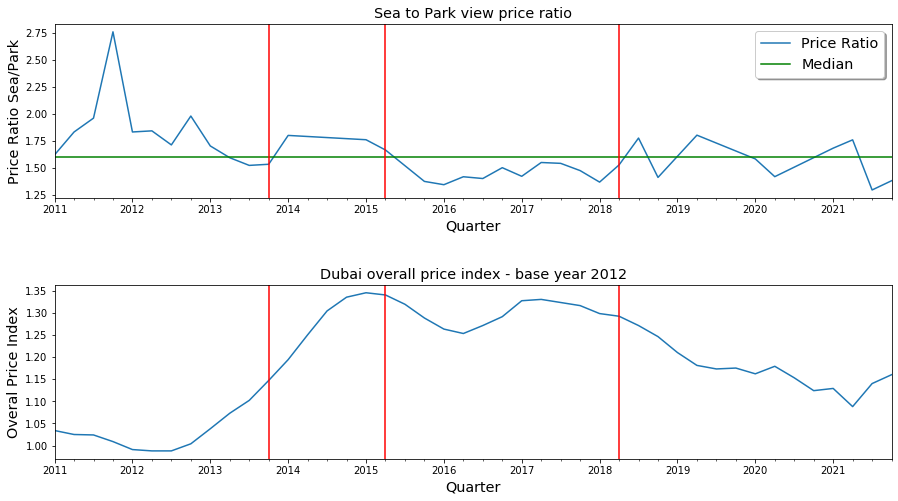

In [883]:
# comparison between the premium and overall market index
fig, axs = plt.subplots(2,1,figsize=(15,8))

# top chart
steady_state_ratio.plot(ax=axs[0], label="Price Ratio");
# show the median
axs[0].axhline(y=steady_state_ratio.median(), color='g', label='Median');
axs[0].set_title("Sea to Park view price ratio", fontsize="x-large");
axs[0].legend(loc='best', shadow=True, fontsize='x-large');
axs[0].set_xlabel("Quarter", fontsize="x-large")
axs[0].set_ylabel("Price Ratio Sea/Park", fontsize="x-large");
axs[0].axvline(x="2013Q4", color='r')
axs[0].axvline(x="2015Q2", color='r')
axs[0].axvline(x="2018Q2", color='r')

# bottom chart
price_index_steady['flat_monthly_index'].plot(ax=axs[1], label='Dubai Overall Price Index');
axs[1].set_title("Dubai overall price index - base year 2012", fontsize="x-large");
axs[1].set_xlabel("Quarter", fontsize="x-large");
axs[1].set_ylabel("Overal Price Index", fontsize="x-large");
axs[1].axvline(x="2013Q4", color='r')
axs[1].axvline(x="2015Q2", color='r')
axs[1].axvline(x="2018Q2", color='r')

# space betwen plots
fig.subplots_adjust(hspace=0.5)

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,5))

steady_state_ratio.plot(ax=axs[0], label="Price Ratio Sea/Park");
# show the median
axs[0.axhline(y=steady_state_ratio.median(), color='g', label='Median');
axs.set_title("Sea to Park view price ratio", fontsize="x-large");
#axs.xaxis.set_label_text("Quarter", fontsize="x-large");
axs.set_xlabel("Quarter", fontsize="x-large")
#axs.yaxis.set_label_text("Price in $ thousands", fontsize="x-large");
axs.set_ylabel("Ratio (Sea/Park view)", fontsize="x-large");
#axs.legend(loc="best", fontsize="x-large");

# set ticks fontsize
for label in (axs.get_xticklabels() + axs.get_yticklabels()):
    label.set_fontsize(12)
    
# format price in thousands
axs.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

## Appendix <a name="appendix"></a>

[(back to index)](#top)

In [761]:
price_index_steady

,first_date_of_month,flat_monthly_index,date
Q,,,
2011Q1,01-03-2011,1.034,2011-03-01
2011Q2,01-06-2011,1.025,2011-06-01
2011Q3,01-09-2011,1.024,2011-09-01
2011Q4,01-12-2011,1.009,2011-12-01
2012Q1,01-03-2012,0.991,2012-03-01
2012Q2,01-06-2012,0.988,2012-06-01
2012Q3,01-09-2012,0.988,2012-09-01
2012Q4,01-12-2012,1.004,2012-12-01
2013Q1,01-03-2013,1.038,2013-03-01


### The CRISP-DM method

We followed the general structure of this method to create this study.

The crisp-dm process. [source](https://www.datascience-pm.com/crisp-dm-2/)

1. Business understanding – What does the business need?
2. Data understanding – What data do we have / need? Is it clean?
3. Data preparation – How do we organize the data for modeling?
4. Modeling – What modeling techniques should we apply?
5. Evaluation – Which model best meets the business objectives?
6. Deployment – How do stakeholders access the results?

### Sample latex code

$\hat{Y} = \hat{\beta}_{0} + \sum \limits _{j=1} ^{p} X_{j}\hat{\beta}_{j} $


### Plotting tests

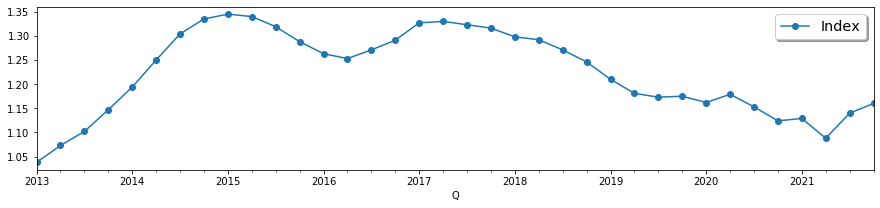

In [663]:
# plot results - by quarter
ax = price_index_steady['flat_monthly_index'].plot(style="-o", figsize=[15,3], label='Index');
# show the median
ax.legend(loc='upper right', shadow=True, fontsize='x-large');

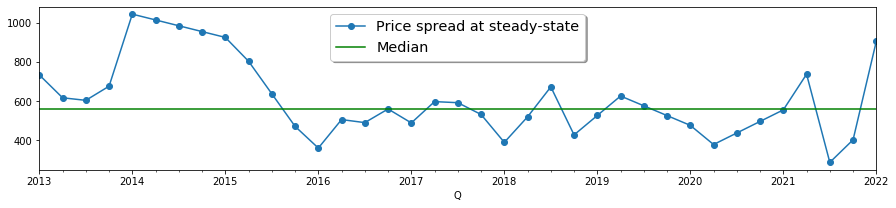

In [664]:
# visualize the difference in price per square foot between sea and park
ax2 = (steady_state_pf).plot(style="-o", figsize=[15,3], label='Price spread at steady-state');
# show the median
ax2.axhline(y=diff_median_steady, color='g', label='Median');
ax2.legend(loc='upper center', shadow=True, fontsize='x-large');

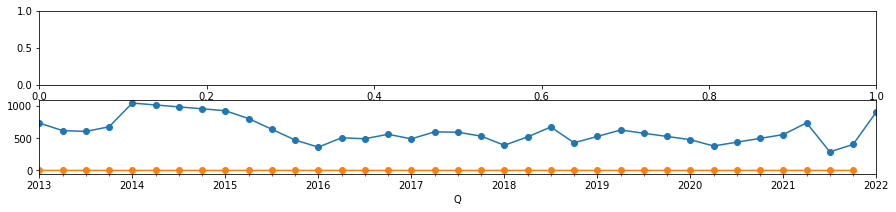

In [706]:
fig, axs = plt.subplots(2, 1)
axs[0] = (steady_state_pf).plot(style="-o", figsize=[15,3], label='Price spread at steady-state')
axs[1] = price_index_steady['flat_monthly_index'].plot(style="-o", figsize=[15,3], label='Index')

In [692]:
axs

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fecb7a9dcd0>,
      dtype=object)

In [693]:
ax

In [694]:
axs[0] = ax

In [696]:
axs[1] = ax2

In [697]:
axs

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fecaa2116d0>,
      dtype=object)

In [700]:
axs.show()

AttributeError: 'numpy.ndarray' object has no attribute 'show'

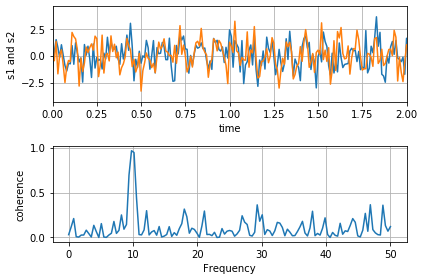

In [683]:
dt = 0.01
t = np.arange(0, 30, dt)
nse1 = np.random.randn(len(t))                 # white noise 1
nse2 = np.random.randn(len(t))                 # white noise 2

# Two signals with a coherent part at 10Hz and a random part
s1 = np.sin(2 * np.pi * 10 * t) + nse1
s2 = np.sin(2 * np.pi * 10 * t) + nse2

fig, axs = plt.subplots(2, 1)
axs[0].plot(t, s1, t, s2)
axs[0].set_xlim(0, 2)
axs[0].set_xlabel('time')
axs[0].set_ylabel('s1 and s2')
axs[0].grid(True)

cxy, f = axs[1].cohere(s1, s2, 256, 1. / dt)
axs[1].set_ylabel('coherence')

fig.tight_layout()
plt.show()


In [686]:
axs

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fecb785ff10>,
      dtype=object)

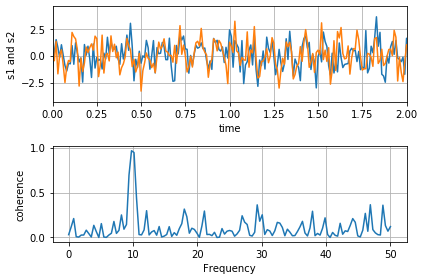

In [687]:
fig

In [707]:
price_index_steady['flat_monthly_index']

Q
2013Q1    1.038
2013Q2    1.073
2013Q3    1.102
2013Q4    1.147
2014Q1    1.194
2014Q2    1.250
2014Q3    1.304
2014Q4    1.335
2015Q1    1.345
2015Q2    1.340
2015Q3    1.319
2015Q4    1.288
2016Q1    1.263
2016Q2    1.253
2016Q3    1.271
2016Q4    1.291
2017Q1    1.327
2017Q2    1.330
2017Q3    1.323
2017Q4    1.316
2018Q1    1.298
2018Q2    1.292
2018Q3    1.271
2018Q4    1.246
2019Q1    1.210
2019Q2    1.181
2019Q3    1.173
2019Q4    1.175
2020Q1    1.162
2020Q2    1.179
2020Q3    1.153
2020Q4    1.124
2021Q1    1.129
2021Q2    1.088
2021Q3    1.140
2021Q4    1.160
Freq: Q-DEC, Name: flat_monthly_index, dtype: float64

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1)

df.groupby('country').plot(x='year', y='unemployment', ax=ax1, legend=False)
df.groupby('country')['unemployment'].mean().sort_values().plot(kind='barh', ax=ax2)

In [ ]:
# plot results - by quarter
ax = price_index_steady['flat_monthly_index'].plot(style="-o", figsize=[15,3], label='Index');
# show the median
ax.legend(loc='upper right', shadow=True, fontsize='x-large');

In [ ]:
# visualize the difference in price per square foot between sea and park
ax2 = (steady_state_pf).plot(style="-o", figsize=[15,3], label='Price spread at steady-state');
# show the median
ax2.axhline(y=diff_median_steady, color='g', label='Median');
ax2.legend(loc='upper center', shadow=True, fontsize='x-large');

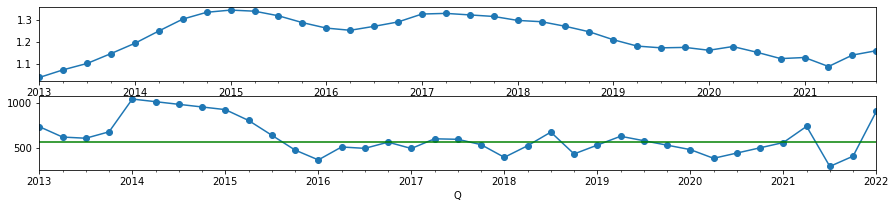

In [710]:
fig, (ax1, ax2) = plt.subplots(2, 1)

price_index_steady['flat_monthly_index'].plot(style="-o", figsize=[15,3], label='Index', ax=ax1)
(steady_state_pf).plot(style="-o", figsize=[15,3], label='Price spread at steady-state', ax=ax2)
ax2.axhline(y=diff_median_steady, color='g', label='Median');

In [717]:
# combine the apartment index and price per square
pd.concat([price_index_steady['flat_monthly_index'], steady_state_pf], axis=1).iloc[:-1]

,flat_monthly_index,pf
Q,,
2013Q1,1.038,733.500000
2013Q2,1.073,617.000000
2013Q3,1.102,604.000000
2013Q4,1.147,676.000000
2014Q1,1.194,1043.000000
2014Q2,1.250,1013.375000
2014Q3,1.304,983.750000
2014Q4,1.335,954.125000
2015Q1,1.345,924.500000


In [731]:
# calculate percentage difference
percentage_sea_park_fs = (quarterly_median_sea_fs / quarterly_median_park_fs)

In [732]:
percentage_sea_park_fs

Q
2009Q1    3.559133
2009Q2    1.655287
2009Q3    0.682839
2009Q4    0.717844
2010Q1    0.966061
2010Q2    0.883172
2010Q3    0.694226
2010Q4    0.988016
2011Q1    1.622844
2011Q2    1.833833
2011Q3    1.962092
2011Q4    2.759717
2012Q1    1.834146
2012Q2    1.844444
2012Q3    1.714535
2012Q4    1.981339
2013Q1    1.704950
2013Q2    1.596135
2013Q3    1.525217
2013Q4    1.535658
2014Q1    1.802308
2014Q2         NaN
2014Q3         NaN
2014Q4         NaN
2015Q1    1.762474
2015Q2    1.667498
2015Q3         NaN
2015Q4    1.377200
2016Q1    1.346782
2016Q2    1.420266
2016Q3    1.403870
2016Q4    1.504050
2017Q1    1.424479
2017Q2    1.551963
2017Q3    1.544118
2017Q4    1.477130
2018Q1    1.370722
2018Q2    1.529532
2018Q3    1.777906
2018Q4    1.414127
2019Q1         NaN
2019Q2    1.804627
2019Q3         NaN
2019Q4         NaN
2020Q1    1.585021
2020Q2    1.421111
2020Q3         NaN
2020Q4         NaN
2021Q1    1.684535
2021Q2    1.761364
2021Q3    1.298137
2021Q4    1.383444
2022Q1    